In [ ]:
# 한 번 돌린 코드

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import shap

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
df = pd.read_csv('cat_1.csv')

# subscriber_count 원본 사용 (로그화 제거)
X = df.drop(['video_id', 'title', 'tags', 'views', 'cat_1', 'popular'], axis=1)
y = df['views']
y_log = np.log1p(y)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# -----------------------------
# 2. CatBoost 모델 학습
# -----------------------------
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
model.fit(X_train, y_train)

# -----------------------------
# 3. 모델 저장
# -----------------------------
model.save_model("model_cat_1_한번.cbm")

# -----------------------------
# 4. SHAP 분석
# -----------------------------
top30_threshold = np.percentile(np.expm1(y_test), 70)
importances = pd.Series(model.get_feature_importance(), index=X.columns)
importances = (importances / importances.sum() * 100).sort_values(ascending=False)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

print("📈 [피처별 영향도 및 조회수 상위 30% 기준 유리 구간]\n")
for feature in importances.index:
    vals = X_test[feature].values
    shap_feat = shap_values[:, X.columns.get_loc(feature)].values

    high_views_idx = np.expm1(y_test) >= top30_threshold
    vals_high = vals[high_views_idx]
    shap_high = shap_feat[high_views_idx]

    pos_vals = vals_high[shap_high > 0]
    neg_vals = vals_high[shap_high < 0]

    if len(pos_vals) > 0:
        low, high = np.percentile(pos_vals, [10, 90])
        trend = "📈 상승"
        range_info = f"[{low:.3f} ~ {high:.3f}]"
    elif len(neg_vals) > 0:
        low, high = np.percentile(neg_vals, [10, 90])
        trend = "📉 하락"
        range_info = f"[{low:.3f} ~ {high:.3f}]"
    else:
        trend = "⚪ 불명확"
        range_info = "-"

    print(f"{feature:<25} | 영향도: {importances[feature]:>6.2f}% | 경향: {trend} | 유리 구간: {range_info}")

# -----------------------------
# 5. 모델 성능 평가
# -----------------------------
from sklearn.metrics import mean_squared_log_error

# 예측
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# 학습셋 지표
r2_train = r2_score(y_train, y_train_pred_log)
mae_train = mean_absolute_error(np.expm1(y_train), y_train_pred)
mae_log_train = mean_absolute_error(y_train, y_train_pred_log)
rmsle_train = np.sqrt(mean_squared_log_error(np.expm1(y_train), y_train_pred))

# 테스트셋 지표
r2_test = r2_score(y_test, y_test_pred_log)
mae_test = mean_absolute_error(np.expm1(y_test), y_test_pred)
mae_log_test = mean_absolute_error(y_test, y_test_pred_log)
rmsle_test = np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_pred))

# 출력
print("✅ 모델 성능 평가\n")
print(f"[학습셋]")
print(f"R² (log scale): {r2_train:.4f}")
print(f"MAE (original scale): {mae_train:,.2f}")
print(f"MAE (log scale): {mae_log_train:.4f}")
print(f"RMSLE: {rmsle_train:.4f}\n")

print(f"[테스트셋]")
print(f"R² (log scale): {r2_test:.4f}")
print(f"MAE (original scale): {mae_test:,.2f}")
print(f"MAE (log scale): {mae_log_test:.4f}")
print(f"RMSLE: {rmsle_test:.4f}\n")


d:\youtube\youtube\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📈 [피처별 영향도 및 조회수 상위 30% 기준 유리 구간]

pub_hour_cos              | 영향도:  15.30% | 경향: 📈 상승 | 유리 구간: [-0.078 ~ 0.078]
pub_day                   | 영향도:  14.87% | 경향: 📈 상승 | 유리 구간: [10.000 ~ 24.800]
pub_weekday_sin           | 영향도:  14.30% | 경향: 📈 상승 | 유리 구간: [-0.650 ~ 0.573]
pub_hour_sin              | 영향도:  13.55% | 경향: 📈 상승 | 유리 구간: [-1.000 ~ 0.966]
pub_weekday_cos           | 영향도:  12.53% | 경향: 📈 상승 | 유리 구간: [-0.901 ~ -0.223]
duration_sec              | 영향도:  10.90% | 경향: 📈 상승 | 유리 구간: [22.000 ~ 290.000]
subscriber_count          | 영향도:   7.98% | 경향: 📈 상승 | 유리 구간: [2550000.000 ~ 7130000.000]
pub_month                 | 영향도:   5.35% | 경향: 📈 상승 | 유리 구간: [2.000 ~ 6.000]
caption_available         | 영향도:   5.23% | 경향: 📈 상승 | 유리 구간: [0.300 ~ 1.000]
definition                | 영향도:   0.00% | 경향: ⚪ 불명확 | 유리 구간: -
✅ 모델 성능 평가

[학습셋]
R² (log scale): 0.9645
MAE (original scale): 187,388.04
MAE (log scale): 0.1446
RMSLE: 0.1985

[테스트셋]
R² (log scale): 0.9002
MAE (original scale): 262,658.24
MAE (log s

In [ ]:
# 반복 학습하면서 오차 줄이기 + 최종 모델 SHAP 분석
# 회귀 분석까지만
'''
목적: 연속적인 수치(views)를 예측하는 것.

사용한 모델: CatBoostRegressor

특징:
- X (피처) → 영상 관련 정보 (title, tags 제외)
- y → 조회수 (views)
- 로그 변환 (y_log = np.log1p(y))을 사용 → 큰 값 대비 안정적 학습

평가 지표:
- MAE (Mean Absolute Error): 예측 오차 절대값 평균, 실제 스케일에서 평가
- R²: 로그 스케일 기준 설명력
- RMSLE: 로그 기반의 오차, 큰 값과 작은 값 모두 고려

코드 특징:
- 10번 반복 학습 → MAE 최소인 최적 모델 선택
- 선택된 모델로 테스트셋 성능 평가
'''

Seed 0 -> MAE (원래 스케일): 127,652.08
Seed 1 -> MAE (원래 스케일): 261,015.32
Seed 2 -> MAE (원래 스케일): 322,539.87
Seed 3 -> MAE (원래 스케일): 397,197.63
Seed 4 -> MAE (원래 스케일): 286,105.36
Seed 5 -> MAE (원래 스케일): 234,331.26
Seed 6 -> MAE (원래 스케일): 223,468.71
Seed 7 -> MAE (원래 스케일): 481,907.51
Seed 8 -> MAE (원래 스케일): 241,137.43
Seed 9 -> MAE (원래 스케일): 176,038.72

✅ MAE 최소 모델
학습셋 MAE: 206,399.80, MAE(log scale): 0.1422, RMSLE: 0.1918, R² (log): 0.9681
테스트셋 MAE: 127,652.08, MAE(log scale): 0.2071, RMSLE: 0.2811, R² (log): 0.9061


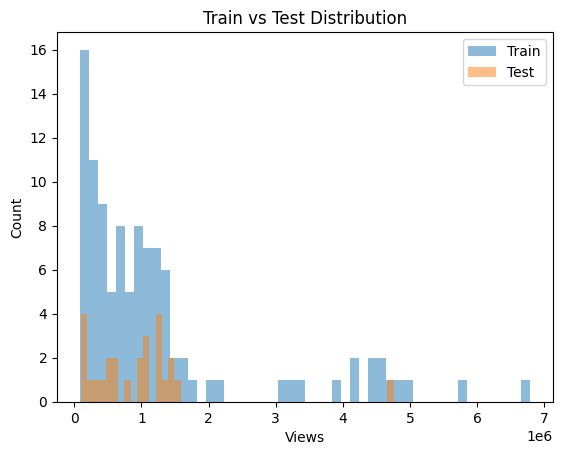


📈 [SHAP 분석: 상위 30% 조회수 기준 유리 구간]

pub_day                   | 영향도:  18.57% | 경향: 📈 상승 | 유리 구간: [10.000 ~ 26.400]
pub_hour_cos              | 영향도:  17.30% | 경향: 📈 상승 | 유리 구간: [-0.000 ~ -0.000]
pub_weekday_cos           | 영향도:  12.98% | 경향: 📈 상승 | 유리 구간: [-0.630 ~ -0.223]
duration_sec              | 영향도:  11.95% | 경향: 📈 상승 | 유리 구간: [264.000 ~ 416.000]
pub_hour_sin              | 영향도:  11.55% | 경향: 📈 상승 | 유리 구간: [-1.000 ~ -1.000]
pub_month                 | 영향도:   9.95% | 경향: 📈 상승 | 유리 구간: [2.000 ~ 4.800]
subscriber_count_log      | 영향도:   9.81% | 경향: 📈 상승 | 유리 구간: [14.752 ~ 15.166]
pub_weekday_sin           | 영향도:   5.87% | 경향: 📈 상승 | 유리 구간: [-0.813 ~ 0.000]
caption_available         | 영향도:   2.02% | 경향: 📈 상승 | 유리 구간: [1.000 ~ 1.000]
definition                | 영향도:   0.00% | 경향: ⚪ 불명확 | 유리 구간: -
✅ 모델 저장 완료: model_cat_1_회귀.cbm


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
df = pd.read_csv('cat_1.csv')

# subscriber_count 로그 변환
df['subscriber_count_log'] = np.log1p(df['subscriber_count'])

# 기존 subscriber_count 제거, 로그 변환 컬럼 사용
X = df.drop(['video_id', 'title', 'tags', 'views', 'cat_1', 'popular', 'subscriber_count'], axis=1)
y = df['views']
y_log = np.log1p(y)

# -----------------------------
# 2. 반복 학습으로 최적 모델 찾기 (MAE 최소)
# -----------------------------
best_mae = float('inf')
best_model_mae = None

for seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=seed)
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        random_seed=seed,
        verbose=0
    )
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    print(f"Seed {seed} -> MAE (원래 스케일): {mae:,.2f}")
    
    if mae < best_mae:
        best_mae = mae
        best_model_mae = model
        best_X_train, best_y_train = X_train, y_train
        best_X_test, best_y_test = X_test, y_test

# -----------------------------
# 3. 학습/테스트셋 평가 함수 (모든 지표 출력)
# -----------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)
    
    # MAE
    mae_train = mean_absolute_error(np.expm1(y_train), y_train_pred)
    mae_test = mean_absolute_error(np.expm1(y_test), y_test_pred)
    
    # 로그 스케일 MAE
    mae_log_train = mean_absolute_error(y_train, y_train_pred_log)
    mae_log_test = mean_absolute_error(y_test, y_test_pred_log)
    
    # RMSLE
    rmsle_train = np.sqrt(mean_squared_log_error(np.expm1(y_train), y_train_pred))
    rmsle_test = np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_pred))
    
    # R² (log scale)
    r2_train = r2_score(y_train, y_train_pred_log)
    r2_test = r2_score(y_test, y_test_pred_log)
    
    print(f"\n✅ MAE 최소 모델")
    print(f"학습셋 MAE: {mae_train:,.2f}, MAE(log scale): {mae_log_train:.4f}, RMSLE: {rmsle_train:.4f}, R² (log): {r2_train:.4f}")
    print(f"테스트셋 MAE: {mae_test:,.2f}, MAE(log scale): {mae_log_test:.4f}, RMSLE: {rmsle_test:.4f}, R² (log): {r2_test:.4f}")
    
    # 학습/테스트 y 분포 시각화
    plt.hist(np.expm1(y_train), bins=50, alpha=0.5, label='Train')
    plt.hist(np.expm1(y_test), bins=50, alpha=0.5, label='Test')
    plt.legend()
    plt.xlabel('Views')
    plt.ylabel('Count')
    plt.title('Train vs Test Distribution')
    plt.show()
    
    # -----------------------------
    # 4. SHAP 분석 (subscriber_count_log 포함)
    # -----------------------------
    top30_threshold = np.percentile(np.expm1(y_test), 70)
    importances = pd.Series(model.get_feature_importance(), index=X.columns)
    importances = (importances / importances.sum() * 100).sort_values(ascending=False)

    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    print("\n📈 [SHAP 분석: 상위 30% 조회수 기준 유리 구간]\n")
    for feature in importances.index:
        vals = X_test[feature].values
        shap_feat = shap_values[:, X.columns.get_loc(feature)].values

        high_views_idx = np.expm1(y_test) >= top30_threshold
        vals_high = vals[high_views_idx]
        shap_high = shap_feat[high_views_idx]

        pos_vals = vals_high[shap_high > 0]
        neg_vals = vals_high[shap_high < 0]

        if len(pos_vals) > 0:
            low, high = np.percentile(pos_vals, [10, 90])
            trend = "📈 상승"
            range_info = f"[{low:.3f} ~ {high:.3f}]"
        elif len(neg_vals) > 0:
            low, high = np.percentile(neg_vals, [10, 90])
            trend = "📉 하락"
            range_info = f"[{low:.3f} ~ {high:.3f}]"
        else:
            trend = "⚪ 불명확"
            range_info = "-"

        print(f"{feature:<25} | 영향도: {importances[feature]:>6.2f}% | 경향: {trend} | 유리 구간: {range_info}")

# 평가 실행
evaluate_model(best_model_mae, best_X_train, best_y_train, best_X_test, best_y_test)

# -----------------------------
# 5. 최종 모델 저장
# -----------------------------
best_model_mae.save_model("model_cat_1_회귀.cbm")
print("✅ 모델 저장 완료: model_cat_1_회귀.cbm")

In [ ]:
'''
회귀 + 분류를 동시에 학습시키는 방법 (CatBoost 기준)

CatBoost에서는 직접적인 멀티태스크(Multi-task) 학습, 즉 한 모델에서 회귀와 분류를 동시에 학습하는 기능은 제공하지 않아.

하지만 실용적인 방법으로는 스택킹(Stacking) 방식을 사용할 수 있어:

1. 회귀 모델 학습
- CatBoostRegressor를 사용해 조회수(views) 같은 연속형 값을 예측
- 예측값(pred_views) 생성

2. 분류 모델 학습
- 기존 피처 X에 회귀 예측값 pred_views를 추가
- popular (0/1) 라벨을 목표값으로 CatBoostClassifier 학습

장점
- 회귀 모델에서 얻은 연속값 정보가 분류 모델 학습에 도움
- 특히 Recall, Precision, F1-score 등 분류 성능 향상 가능

요약: CatBoost로 멀티태스크를 직접 구현하지 않아도, 회귀 예측값을 분류 모델 피처로 활용하는 스택킹 방식으로 회귀 + 분류 정보를 결합할 수 있다.
'''

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
df = pd.read_csv('cat_1.csv')

# subscriber_count 로그 변환
df['subscriber_count_log'] = np.log1p(df['subscriber_count'])

# 회귀용 X, y
X = df.drop(['video_id', 'title', 'tags', 'views', 'cat_1', 'popular', 'subscriber_count'], axis=1)
y = df['views']
y_log = np.log1p(y)

# 분류용 y
y_cls = df['popular']  # 0 또는 1

# -----------------------------
# 2. 반복 학습으로 최적 회귀 모델 찾기 (MAE 최소)
# -----------------------------
best_mae = float('inf')
best_model_mae = None

for seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=seed)
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        random_seed=seed,
        verbose=0
    )
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    print(f"Seed {seed} -> MAE (원래 스케일): {mae:,.2f}")
    
    if mae < best_mae:
        best_mae = mae
        best_model_mae = model
        best_X_train, best_y_train = X_train, y_train
        best_X_test, best_y_test = X_test, y_test

print(f"\n✅ 선택된 회귀 모델 MAE (테스트셋): {best_mae:,.2f}")

# -----------------------------
# 3. 회귀 모델 평가
# -----------------------------
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)
    
    mae_train = mean_absolute_error(np.expm1(y_train), y_train_pred)
    mae_test = mean_absolute_error(np.expm1(y_test), y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_log)
    r2_test = r2_score(y_test, y_test_pred_log)
    rmsle_train = np.sqrt(mean_squared_log_error(np.expm1(y_train), y_train_pred))
    rmsle_test = np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_pred))
    
    print(f"\n✅ 회귀 모델 평가")
    print(f"[학습셋] MAE: {mae_train:,.2f}, R²(log): {r2_train:.4f}, RMSLE: {rmsle_train:.4f}")
    print(f"[테스트셋] MAE: {mae_test:,.2f}, R²(log): {r2_test:.4f}, RMSLE: {rmsle_test:.4f}")

evaluate_regression(best_model_mae, best_X_train, best_y_train, best_X_test, best_y_test)

# -----------------------------
# 4. 분류 모델 학습 (회귀 예측값 추가)
# -----------------------------
# 전체 데이터에 대해 회귀 모델로 예측값 생성
X_cls = X.copy()
X_cls['pred_views'] = best_model_mae.predict(X)

# 학습/테스트 분리
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

# CatBoostClassifier 학습
cls_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
cls_model.fit(X_train_cls, y_train_cls)

# -----------------------------
# 5. 분류 모델 평가 (모든 지표 출력)
# -----------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred_cls = cls_model.predict(X_test_cls)

acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)

print("\n✅ 분류 모델 성능 평가")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

cm = confusion_matrix(y_test_cls, y_pred_cls)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_cls))

# -----------------------------
# 6. SHAP 분석 (분류 기준)
# -----------------------------
top1_threshold = 1  # popular=1 기준
importances_cls = pd.Series(cls_model.get_feature_importance(), index=X_cls.columns)
importances_cls = (importances_cls / importances_cls.sum() * 100).sort_values(ascending=False)

explainer_cls = shap.Explainer(cls_model)
shap_values_cls = explainer_cls(X_test_cls)

print("\n📈 [SHAP 분석: 분류 모델 기준]\n")
for feature in importances_cls.index:
    vals = X_test_cls[feature].values
    shap_feat = shap_values_cls[:, X_cls.columns.get_loc(feature)].values

    pos_vals = vals[shap_feat > 0]
    neg_vals = vals[shap_feat < 0]

    if len(pos_vals) > 0:
        low, high = np.percentile(pos_vals, [10, 90])
        trend = "📈 상승"
        range_info = f"[{low:.3f} ~ {high:.3f}]"
    elif len(neg_vals) > 0:
        low, high = np.percentile(neg_vals, [10, 90])
        trend = "📉 하락"
        range_info = f"[{low:.3f} ~ {high:.3f}]"
    else:
        trend = "⚪ 불명확"
        range_info = "-"

    print(f"{feature:<25} | 영향도: {importances_cls[feature]:>6.2f}% | 경향: {trend} | 유리 구간: {range_info}")

# -----------------------------
# 7. 모델 저장 (회귀+분류)
# -----------------------------
# 회귀 모델 저장
best_model_mae.save_model("model_cat_1_회귀_분류.cbm")
print("✅ 모델 저장 완료: model_cat_1_회귀_분류.cbm")


Seed 0 -> MAE (원래 스케일): 127,652.08
Seed 1 -> MAE (원래 스케일): 261,015.32
Seed 2 -> MAE (원래 스케일): 322,539.87
Seed 3 -> MAE (원래 스케일): 397,197.63
Seed 4 -> MAE (원래 스케일): 286,105.36
Seed 5 -> MAE (원래 스케일): 234,331.26
Seed 6 -> MAE (원래 스케일): 223,468.71
Seed 7 -> MAE (원래 스케일): 481,907.51
Seed 8 -> MAE (원래 스케일): 241,137.43
Seed 9 -> MAE (원래 스케일): 176,038.72

✅ 선택된 회귀 모델 MAE (테스트셋): 127,652.08

✅ 회귀 모델 평가
[학습셋] MAE: 206,399.80, R²(log): 0.9681, RMSLE: 0.1918
[테스트셋] MAE: 127,652.08, R²(log): 0.9061, RMSLE: 0.2811

✅ 분류 모델 성능 평가
Accuracy : 0.9615
Precision: 1.0000
Recall   : 0.8750
F1-score : 0.9333

Confusion Matrix:
[[18  0]
 [ 1  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.88      0.93         8

    accuracy                           0.96        26
   macro avg       0.97      0.94      0.95        26
weighted avg       0.96      0.96      0.96        26


📈 [SHAP 분석: 분류 모